In [1]:
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from pyvis.network import Network

In [2]:
# Load the updated JSON data
with open('geo_location/updated.json', 'r') as file:
    geo_data = json.load(file)

In [3]:
# Convert the data to a DataFrame
df = pd.DataFrame(geo_data).transpose()
df = df[df['country'].notnull()]

# Show the first few rows of the DataFrame
display(df)

,preferred name,first name,last name,aliases,affiliations,article count,publication topics,coAuthors,author publications,country
99659859971,none,Junyi,Shu,none,[Peking University],2,"[{'id': 'none', 'name': 'External storage', 'n...","[{'id': '99659853258', 'preferred name': 'none...",none,China
99659853258,none,Xin,Jin,none,[Peking University],18,"[{'id': 'none', 'name': 'Cloud computing', 'nu...","[{'id': '84459109657', 'preferred name': 'none...",none,China
84758643357,none,Yun,Ma,none,"[Peking University, Tsinghua University, Key L...",34,"[{'id': 'none', 'name': 'Software testing and ...","[{'id': '81350600064', 'preferred name': 'none...",none,China
84459152157,none,Xuanzhe,Liu,none,"[Peking University, Key Lab of High Confidence...",93,"[{'id': 'none', 'name': 'Web applications', 'n...","[{'id': '84459109657', 'preferred name': 'none...",none,China
81350600064,none,Gang,Huang,none,"[Peking University, Key Lab of High Confidence...",124,"[{'id': 'none', 'name': 'Software architecture...","[{'id': '84459109657', 'preferred name': 'none...",none,China
...,...,...,...,...,...,...,...,...,...,...
81100592757,none,Todd,Alan Proebsting,none,"[The University of Arizona, Microsoft Research...",40,"[{'id': 'none', 'name': 'Compilers', 'numRecor...","[{'id': '81100132568', 'preferred name': 'none...",none,United States
81100534748,none,Chungshyan,Liu,none,[Chung Yuan Christian University],3,"[{'id': 'none', 'name': 'Network protocols', '...",[],none,"Taiwan, Province of China"
81452604235,none,Simon,S Lam,none,"[The University of Texas at Austin, IEEE]",116,"[{'id': 'none', 'name': 'Network protocols', '...","[{'id': '81542072156', 'preferred name': 'none...",none,United States
81100012520,none,D.,L. Mills,none,"[Fountainhead College of Technology, Universit...",42,"[{'id': 'none', 'name': 'Network protocols', '...",[],none,United States


In [4]:
country_counts = df['country'].value_counts()

num_unique_countries = df['country'].nunique()
print(f"Number of different countries: {num_unique_countries}")

Number of different countries: 53


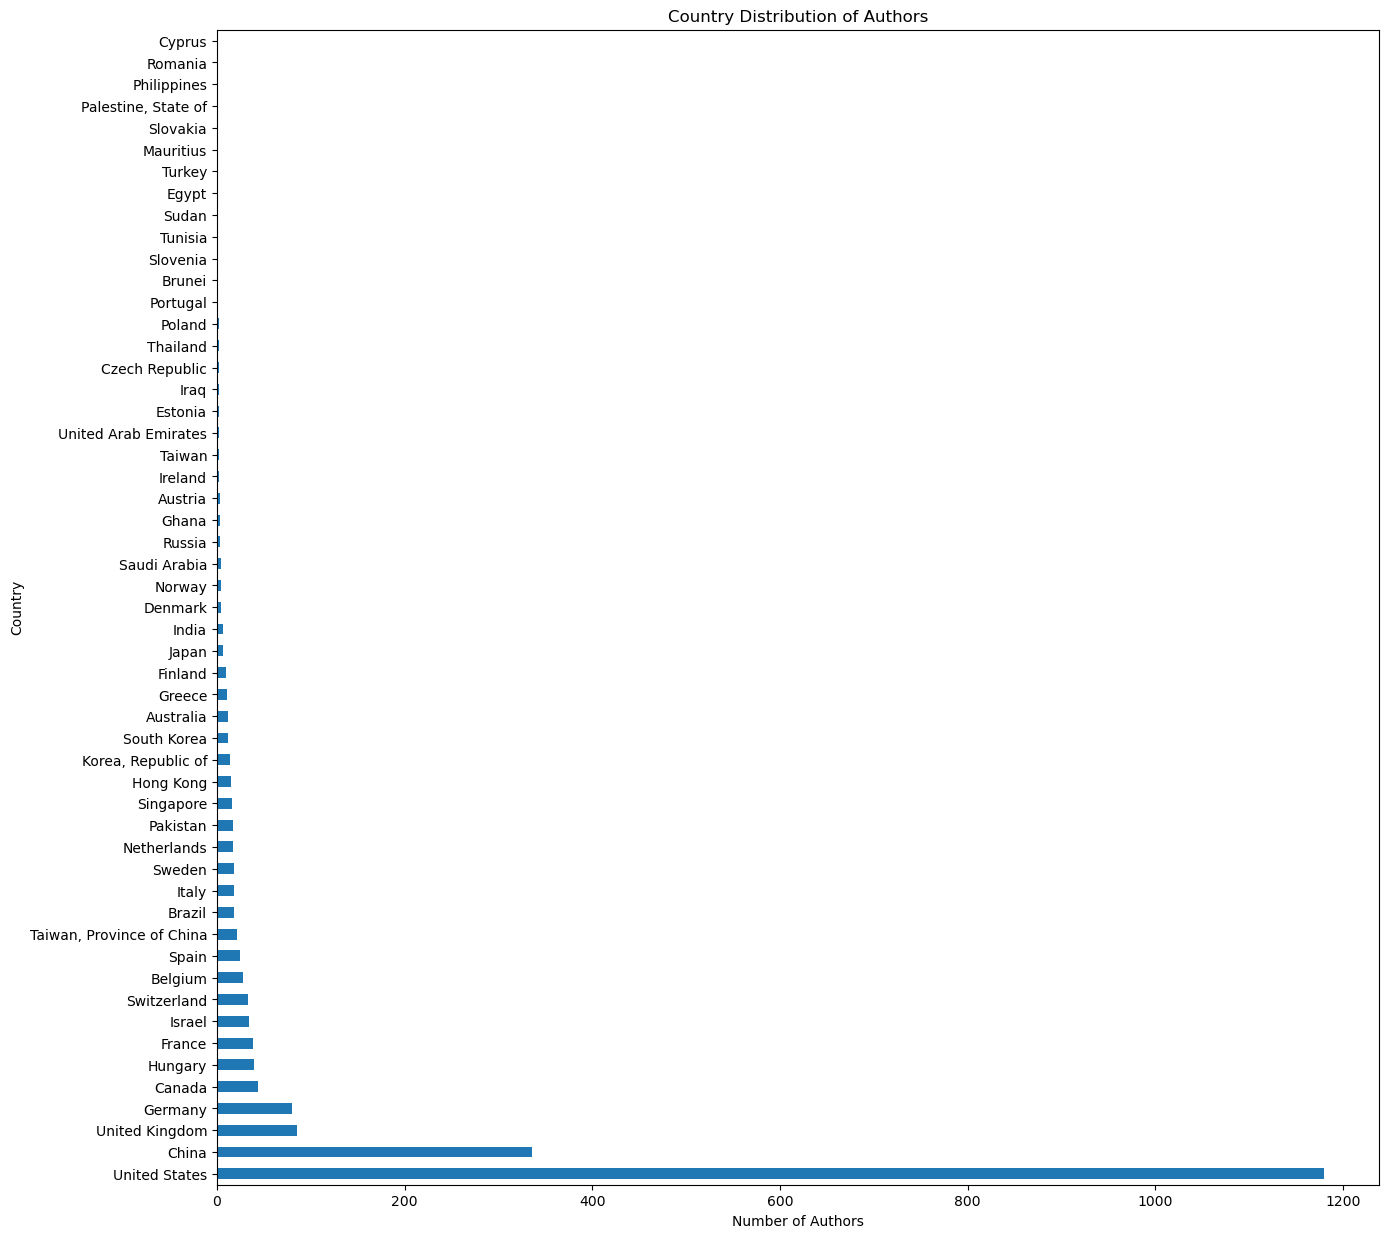

In [5]:
# Plot the country distribution as a horizontal bar chart
plt.figure(figsize=(15, 15))
country_counts.plot(kind='barh')
plt.title('Country Distribution of Authors')
plt.xlabel('Number of Authors')
plt.ylabel('Country')
plt.show()

Collaboration Patterns over Countries

In [6]:
df['coAuthors'] = df['coAuthors'].apply(lambda coauthors: [coauthor['id'] for coauthor in coauthors])

In [7]:
# Initialize a graph
G = nx.Graph()

# Dictionary to keep track of collaborations between countries
collaboration_counts = defaultdict(int)

# Dictionary to keep track of the number of authors per country
country_author_counts = defaultdict(int)

# Iterate over each author in the DataFrame
for _, author in df.iterrows():
    author_country = author['country']
    coAuthors = author['coAuthors']
    
    # Increment the author count for the author's country
    country_author_counts[author_country] += 1
    
    # Set to track pairs of countries for this author to avoid duplicate counting within the same author's row
    seen_pairs = set()
    
    # Find countries of co-authors
    for coAuthor_id in coAuthors:
        if coAuthor_id in df.index:
            coAuthor_country = df.loc[coAuthor_id, 'country']
            
            # Ensure both authors are from different countries and neither is None
            if author_country and coAuthor_country and author_country != coAuthor_country:
                # Create a sorted tuple to uniquely identify the collaboration
                collaboration = tuple(sorted([author_country, coAuthor_country]))
                
                # Check if this collaboration has already been counted for this author
                if collaboration not in seen_pairs:
                    collaboration_counts[collaboration] += 1
                    seen_pairs.add(collaboration)

# Add edges to the graph with weights
for (country1, country2), weight in collaboration_counts.items():
    G.add_edge(country1, country2, weight=weight)

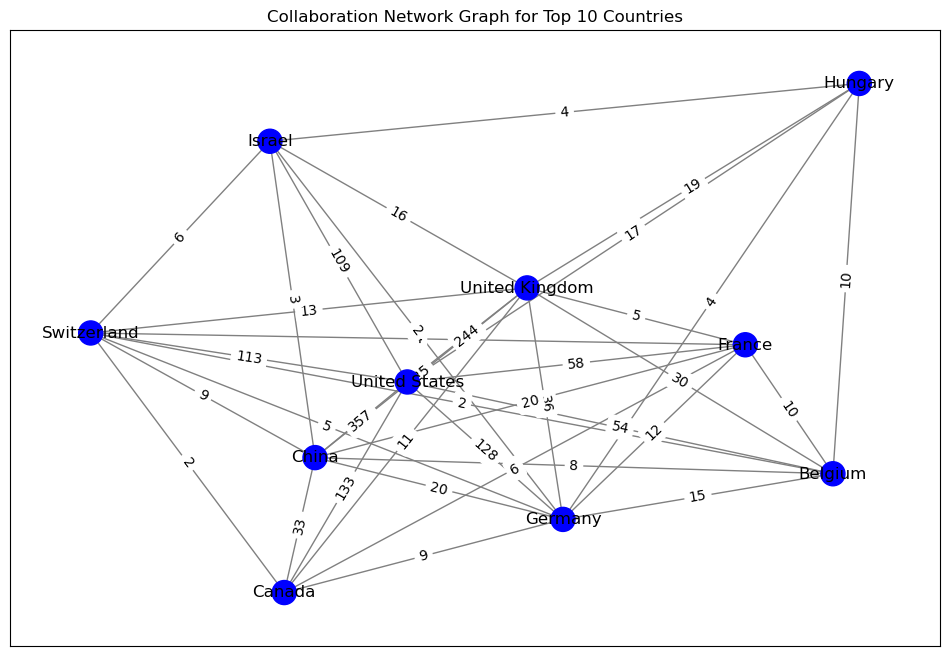

In [8]:
# Find the top 10 countries with the most authors
top_10_countries = sorted(country_author_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_country_names = [country for country, count in top_10_countries]

# Create a subgraph for the top 10 countries
subgraph_edges = [(u, v) for u, v in G.edges() if u in top_10_country_names and v in top_10_country_names]
G_top10 = G.edge_subgraph(subgraph_edges).copy()

# Set node attributes for the top 10 countries
for node in G_top10.nodes():
    if node in top_10_country_names:
        G_top10.nodes[node]['color'] = 'blue'
        G_top10.nodes[node]['size'] = 300
    else:
        G_top10.nodes[node]['color'] = 'blue'
        G_top10.nodes[node]['size'] = 100

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_top10, seed=42)  # Positions for all nodes

# Draw nodes with colors and sizes
node_colors = [G_top10.nodes[node]['color'] for node in G_top10.nodes()]
node_sizes = [G_top10.nodes[node]['size'] for node in G_top10.nodes()]
nx.draw_networkx_nodes(G_top10, pos, node_color=node_colors, node_size=node_sizes)

# Draw edges
nx.draw_networkx_edges(G_top10, pos, edge_color='gray')

# Draw labels for the top 10 countries
nx.draw_networkx_labels(G_top10, pos, labels={node: node for node in top_10_country_names}, font_size=12, font_family='sans-serif')

# Draw edge labels to show weights
edge_labels = nx.get_edge_attributes(G_top10, 'weight')
nx.draw_networkx_edge_labels(G_top10, pos, edge_labels=edge_labels)

plt.title('Collaboration Network Graph for Top 10 Countries')
plt.show()

In [9]:
degree_centrality = nx.degree_centrality(G)
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 Countries by Degree Centrality:")
for name, value in top_degree:
    print(f"{name}: {value:.4f}")

Top 5 Countries by Degree Centrality:
United States: 0.9216
China: 0.6471
United Kingdom: 0.6471
Germany: 0.6471
France: 0.4314


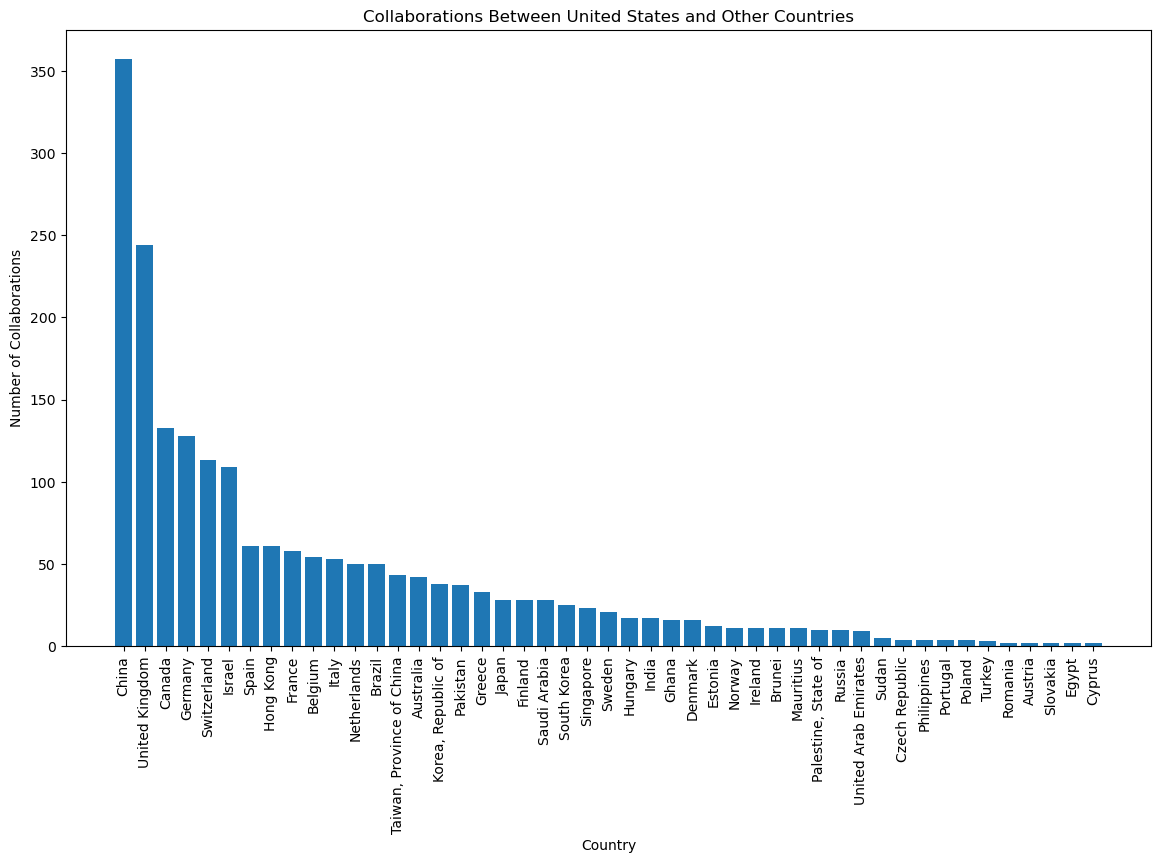

In [10]:
# Filter collaborations involving the United States
us_collaborations = {(country1 if country2 == 'United States' else country2): weight 
                     for (country1, country2), weight in collaboration_counts.items()
                     if country1 == 'United States' or country2 == 'United States'}

# Create a DataFrame for easy plotting
us_collaborations_df = pd.DataFrame(list(us_collaborations.items()), columns=['Country', 'Collaborations'])

# Sort the DataFrame by number of collaborations
us_collaborations_df = us_collaborations_df.sort_values(by='Collaborations', ascending=False)

# Plot the data
plt.figure(figsize=(14, 8))
plt.bar(us_collaborations_df['Country'], us_collaborations_df['Collaborations'])
plt.title('Collaborations Between United States and Other Countries')
plt.xlabel('Country')
plt.ylabel('Number of Collaborations')
plt.xticks(rotation=90)
plt.show()